In [205]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np

import warnings
warnings.filterwarnings('ignore')

## Preprocessing and Visualisation

In [206]:
df = pd.read_csv("clean-dirty-metadata.csv",sep=';')
df = df.drop(['source','x_lat','y_lon','annotation_path'],axis=1)
df["label"] = (df["label"] == "clean").astype(int)
df

,image_path,split,label
0,clean-dirty-garbage-containers/train/clean/001...,train,1
1,clean-dirty-garbage-containers/train/clean/001...,train,1
2,clean-dirty-garbage-containers/train/clean/001...,train,1
3,clean-dirty-garbage-containers/train/clean/001...,train,1
4,clean-dirty-garbage-containers/train/clean/001...,train,1
...,...,...,...
3407,clean-dirty-garbage-containers/test/dirty/e8e1...,test,0
3408,clean-dirty-garbage-containers/test/dirty/f02b...,test,0
3409,clean-dirty-garbage-containers/test/dirty/f29b...,test,0
3410,clean-dirty-garbage-containers/test/dirty/fc02...,test,0


In [207]:
IMG_WIDTH=200
IMG_HEIGHT=200

#get pathname and convert the image into the right shape
df["images"]=""
for i in range(len(df)) :
    im = cv2.imread(df["image_path"][i].partition("/")[2], cv2.COLOR_BGR2GRAY)
    image = cv2.resize(im, (IMG_HEIGHT, IMG_WIDTH))
    image = np.array(image)
    image = image.astype('float32')
    image /= 255 
    df["images"][i]=image.astype(float)
    

In [208]:
'''# to have a smaller dataset to work with
from sklearn.utils import shuffle
df = shuffle(df)
df1 = df[:200]
df1
'''
# split into train and test
df_train = df[df.split == 'train']
df_test = df[df.split == 'test']

#keep interesting column
train_df = df_train.drop(['image_path','split'],axis=1)
test_df = df_test.drop(['image_path','split'],axis=1)

<AxesSubplot:ylabel='count'>

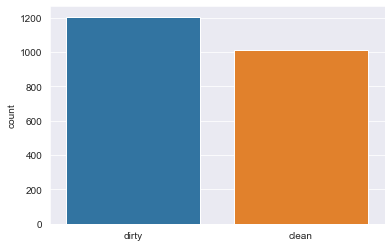

In [209]:
#visualisation to see if my dataset is balance
l = []
for i in df_train.label:
    if(i == 0):
        l.append("clean")
    else:
        l.append("dirty")
sns.set_style('darkgrid')
sns.countplot(l)

In [210]:
#Convert the target arrays to one-hot encodings
from keras.utils.np_utils import to_categorical
y_train = tf.keras.utils.to_categorical(
    train_df['label'], num_classes=None, dtype='float32'
)

y_test = tf.keras.utils.to_categorical(
    test_df['label'], num_classes=None, dtype='float32'
)

In [211]:
#convert to numpy array 
#!!! suppose to be the same for test but there is a bug and I will deal with it later(tired!!)
train = []
for i in range(len(train_df)):
    train.append(train_df['images'][i])
train = np.array(train)

In [228]:
x_train = train

In [229]:
print("Shape of training data", x_train.shape)
#print("\nShape of test data", x_test.shape)

Shape of training data (2217, 200, 200, 3)


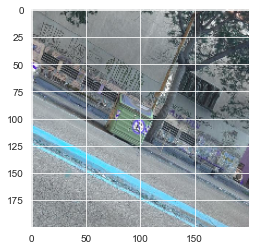

In [231]:
plt.imshow(x_train[600]) #example

## First Naive model

In [232]:
# Define Sequential model with 3 layers
from tensorflow.keras import layers

model = tf.keras.Sequential(
    [   tf.keras.Input(shape=(32,32,3)),
        layers.Flatten(),
        layers.Dense(2048, activation="relu", name="layer1"),
        layers.Dense(1024, activation="relu", name="layer2"),
        layers.Dense(512, activation="relu", name="layer3"),
        layers.Dense(256, activation="relu", name="layer4"),
        layers.Dense(10, activation='softmax')
    ])

model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
layer1 (Dense)               (None, 2048)              6293504   
_________________________________________________________________
layer2 (Dense)               (None, 1024)              2098176   
_________________________________________________________________
layer3 (Dense)               (None, 512)               524800    
_________________________________________________________________
layer4 (Dense)               (None, 256)               131328    
_________________________________________________________________
dense (Dense)                (None, 10)                2570      
Total params: 9,050,378
Trainable params: 9,050,378
Non-trainable params: 0
______________________________________________

In [233]:
# I have to  deal with the y_train thing
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=2)

history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=10,
    validation_data=(0.1*x_train, 0.1*y_train),callbacks=es)

Epoch 1/10


ValueError: in user code:

    /Users/haliouanaomie/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /Users/haliouanaomie/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/haliouanaomie/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/haliouanaomie/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/haliouanaomie/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/haliouanaomie/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /Users/haliouanaomie/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /Users/haliouanaomie/opt/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/haliouanaomie/opt/anaconda3/lib/python3.8/site-packages/keras/engine/sequential.py:369 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /Users/haliouanaomie/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:414 call
        return self._run_internal_graph(
    /Users/haliouanaomie/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:550 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /Users/haliouanaomie/opt/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/haliouanaomie/opt/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py:250 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer layer1 is incompatible with the layer: expected axis -1 of input shape to have value 3072 but received input with shape (None, 120000)
